# Xception
- CIFAR10 dataset is used to train the pre-trained model **Xception**. 
- Only the labelled dataset is used in this model.
- Fine-tuning of the model is also done, through freezing the layer, adding new layers to the model etc.
- The hyper-parameter tuning regarding the **#epochs** is fixed and carried out similarly in all the kernels. We have tried **[10, 20, 30, 40, 50]** epochs, and for the final model, selected the setting (#epochs) with the largest test accuracy.

# Importing the Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tabulate import tabulate
from sklearn.metrics import accuracy_score, log_loss, f1_score

# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception

In [2]:
# Making sure that Tensorflow is able to detect the GPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Defining a function to list the memory consumed
# Only outputs variables taking at least 1MB space
def list_storage(inp_dir):
    # Get a sorted list of the objects and their sizes
    vars_defined = [x for x in inp_dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    sto = sorted([(x, sys.getsizeof(globals().get(x))) for x in vars_defined], key=lambda x: x[1], reverse=True)
    sto = [(x[0], str(round((x[1] / 2**20), 2)) + ' MB') for x in sto if x[1] >= 2**20]
    print(tabulate(sto, headers = ['Variable', 'Storage (in MB)']))

# In order to use this function, use the below line of code
# list_storage(dir())

In [4]:
# Importing the Labelled Dataset
df_train = pd.read_csv("../input/cifar10/train_lab_x.csv")
y_train = pd.read_csv("../input/cifar10/train_lab_y.csv")

# Importing the Test Dataset
df_test = pd.read_csv("../input/cifar10/test_x.csv")
y_test = pd.read_csv("../input/cifar10/test_y.csv")

# Basic Pre-processing

(40006, 3072) (40006, 1)
(40006, 3, 32, 32)
[0]


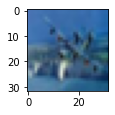

In [5]:
df_train = np.array(df_train)
y_train = np.array(y_train)
print(df_train.shape, y_train.shape)

# Reshaping the dataset
df_train = np.reshape(df_train, (-1, 3, 32, 32))
print(df_train.shape)

# Visualizing a single image
ind = 15
example = df_train[ind, : , : , : ]
example = example.transpose((1, 2, 0))
plt.figure(figsize=(1.5, 1.5))
plt.imshow(example)
print(y_train[ind])

In [6]:
# Creating a random permutation
perm = np.random.permutation(df_train.shape[0])

# Shuffling the training dataset
df_train = df_train[perm, : , : , : ]
y_train = y_train[perm]

# Reshaping, rescaling and one-hot encoding
df_train = np.transpose(np.array(df_train), (0, 2, 3, 1))
df_train = df_train / 255
y_train_oh = tf.one_hot(np.ravel(y_train), depth = 10)

print(df_train.shape, y_train_oh.shape)

(40006, 32, 32, 3) (40006, 10)


In [7]:
df_test = np.array(df_test)
y_test = np.array(y_test)
print(df_test.shape, y_test.shape)

# Reshaping the dataset
df_test = np.reshape(df_test, (-1, 3, 32, 32))
print(df_test.shape)

# Reshaping, rescaling and one-hot encoding
df_test = np.transpose(np.array(df_test), (0, 2, 3, 1))
df_test = df_test / 255
y_test_oh = tf.one_hot(np.ravel(y_test), depth = 10)
print(df_test.shape, y_test_oh.shape)

(10000, 3072) (10000, 1)
(10000, 3, 32, 32)
(10000, 32, 32, 3) (10000, 10)


# Training & Hyperparamater-Tuning for the Model

In [8]:
to_res = (64, 64)

In [9]:
# If the model has been pre-trained
try:
    model = tf.keras.models.load_model('../input/dcai-rw/xcptn_model.h5')
    
# If the model hasn't been pre-trained
except:
    input_t = tf.keras.Input(shape = (64, 64, 3))
    xcptn_model = Xception(weights='imagenet', include_top=False, input_tensor=input_t,
                                 pooling='max')
    xcptn_model.summary()
    
    for layer in xcptn_model.layers:
        layer.trainable = True

    for i, layer in enumerate(xcptn_model.layers):
        print(i, layer.name, "-", layer.trainable)
        
    model = tf.keras.models.Sequential()
    model.add(layers.Lambda(lambda image: tf.image.resize(image, to_res))) 
    model.add(xcptn_model)
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    
    loss = 'categorical_crossentropy'
    opt = tf.keras.optimizers.Adam(learning_rate=2e-5)
    metrics = ['accuracy']

    model.compile(loss = loss, optimizer = opt, metrics = metrics)
    model.build((None, 64, 64, 3))
    model.summary()
    
    # Composing the Train Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((df_train, y_train_oh)).batch(32)

    num_epochs = [10, 20, 30, 40, 50]
    train_loss, test_loss, train_acc, test_acc = [], [], [], []

    for epochs in num_epochs:
        # Training the Model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
        model.fit(train_dataset, epochs = epochs)

        # Predicting on the Train/Test Datasets
        preds_train = model.predict(df_train)
        preds_test = model.predict(df_test)

        # Finding the Predicted Classes
        cls_train = np.argmax(preds_train, axis = 1)
        cls_test = np.argmax(preds_test, axis = 1)

        # Finding the Train/Test set Loss
        train_loss.append(log_loss(y_train_oh, preds_train))
        test_loss.append(log_loss(y_test_oh, preds_test))
        train_acc.append(accuracy_score(y_train, cls_train))
        test_acc.append(accuracy_score(y_test, cls_test))

        print("For ", epochs, " Epochs:")
        print("Log-loss for Train Dataset = ", train_loss[-1])
        print("Log-loss for Test Dataset = ", test_loss[-1])
        print("Accuracy for Train Dataset = ", train_acc[-1])
        print("Accuracy for Test Dataset = ", test_acc[-1])
        print()
    
    # Training the Model with the best hyper-parameter settings
    ind = np.argmax(test_acc)
    best_num_epochs = num_epochs[ind]

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    model.fit(train_dataset, epochs = best_num_epochs)
    model.save('xcptn_model.h5')
    model = tf.keras.models.load_model('./xcptn_model.h5')

# Predicting & Evaluating on Train/Test Datasets

In [10]:
# Predicting on the Train/Test Datasets
preds_train = model.predict(df_train)
preds_test = model.predict(df_test)

# Finding the Predicted Classes
train_cls = np.argmax(preds_train, axis = 1)
test_cls = np.argmax(preds_test, axis = 1)

In [11]:
print("Accuracy for Train Dataset = ", accuracy_score(y_train, train_cls))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, test_cls))

print("Log-loss for Train Dataset = ", log_loss(y_train_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))

print("F1 Score for Train Dataset = ", f1_score(y_train, train_cls, average='weighted'))
print("F1 Score for Test Dataset = ", f1_score(y_test, test_cls, average='weighted')) 

Accuracy for Train Dataset =  0.9972504124381343
Accuracy for Test Dataset =  0.8957
Log-loss for Train Dataset =  0.009731522791650571
Log-loss for Test Dataset =  0.8017136794626224
F1 Score for Train Dataset =  0.997250047109037
F1 Score for Test Dataset =  0.8956651393697893
